# Training Comparisons and Evaluations

##### Authors:
1. Ovidio Manteiga Moar
1. Carlos Villar Martínez

In this notebook the goal is to train a VAE. The process is similar than for the other VAE that we tried so we will explain it on detail justin this notebook.

The first thing that we need to do is toimport the needed libraries and functions.

In [9]:
from Data_pre import prepare_data_generator_VAE
import numpy as np
import glob, os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, callbacks, utils, metrics, optimizers
from keras.callbacks import ModelCheckpoint 
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
import PIL

## VAE

We define the folder with the dataset. This depends on the computer we are using.

In [10]:
DATA_FOLDER = "./Dataset/img_align_celeba"

Next, we define some parameters and we do the data preprocessing. To do this we use a function defined in the Data_pre.py file:

```python
def prepare_data_generator_VAE(data_folder, input_dim=(128, 128, 3), batch_size=512):
    if not os.path.exists(data_folder):
        raise ValueError("Invalid data folder path.")

    filenames = np.array(glob.glob(os.path.join(data_folder, '*/*.jpg')))
    num_images = len(filenames)
    print(f"Total number of images: {num_images}")

    data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(data_folder, 
        target_size = input_dim[:2],
        batch_size = batch_size,
        shuffle = True,
        class_mode = 'input',
        subset = 'training',
        color_mode=('grayscale' if input_dim[2]==1 else 'rgb')
        )

    return data_flow, num_images

```

Now we define some hyperparameters, this is an important step because depending on the hyperparameters that we use the results are going to be better or worse. There is not a magic formula to find the best combination of hyperparameters it is all a matter of trial and error. 

In [11]:
INPUT_DIM = (64, 64, 1)
BATCH_SIZE = 4096
Z_DIM = 100

data_flow, NUM_IMAGES = prepare_data_generator_VAE(DATA_FOLDER, INPUT_DIM, BATCH_SIZE)

Total number of images: 202599
Found 202599 images belonging to 1 classes.


As we know, now we have to define encoder, decoder and put them toguether.

First of all lets define the encoder.

In [12]:
# ENCODER
def build_vae_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, conv_strides):
  
    # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
    # BatchNormalization and Dropout.
    # Otherwise, the names of above mentioned layers in the model 
    # would be inconsistent
    global K
    K.clear_session()
    
    # Number of Conv layers
    n_layers = len(conv_filters)

    # Define model input
    encoder_input = Input(shape = input_dim, name = 'encoder_input')
    x = encoder_input

    # Add convolutional layers
    for i in range(n_layers):
        x = Conv2D(filters = conv_filters[i], 
            kernel_size = conv_kernel_size[i],
            strides = conv_strides[i], 
            padding = 'same',
            name = 'encoder_conv_' + str(i)
            )(x)

        x = LeakyReLU()(x)
        
    # Required for reshaping latent vector while building Decoder
    shape_before_flattening = K.int_shape(x)[1:] 
    
    x = Flatten()(x)
    mean_mu = Dense(output_dim, name = 'mu')(x)
    log_var = Dense(output_dim, name = 'log_var')(x)

    # Defining a function for sampling
    def sampling(args):
        mean_mu, log_var = args
        epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
        return mean_mu + K.exp(log_var/2)*epsilon   

    # Using a Keras Lambda Layer to include the sampling function as a layer 
    # in the model
    encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])


    return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, Model(encoder_input, encoder_output)


vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder  = build_vae_encoder(
    input_dim = INPUT_DIM,
    output_dim = Z_DIM, 
    #conv_filters = [32, 64, 64, 64],
    conv_filters = [16, 32, 32, 32],
    conv_kernel_size = [3,3,3,3],
    conv_strides = [2,2,2,2])

vae_encoder.summary()

plot_model(vae_encoder, show_shapes=True, show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 32, 32, 16)   160         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 16)   0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 16, 16, 32)   4640        ['leaky_re_lu[0][0]']            
                                                                                              

Lets go now with the decoder

In [13]:
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, conv_strides):

    # Number of Conv layers
    n_layers = len(conv_filters)

    # Define model input
    decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

    # To get an exact mirror image of the encoder
    x = Dense(np.prod(shape_before_flattening))(decoder_input)
    x = Reshape(shape_before_flattening)(x)

    # Add convolutional layers
    for i in range(n_layers):
        x = Conv2DTranspose(
            filters = conv_filters[i], 
            kernel_size = conv_kernel_size[i],
            strides = conv_strides[i], 
            padding = 'same',
            name = 'decoder_conv_' + str(i)
            )(x)
        
        # Adding a sigmoid layer at the end to restrict the outputs 
        # between 0 and 1
        if i < n_layers - 1:
            x = LeakyReLU()(x)
        else:
            x = Activation('sigmoid')(x)

    # Define model output
    decoder_output = x

    return decoder_input, decoder_output, Model(decoder_input, decoder_output)

decoder_input, decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM,
    shape_before_flattening = vae_shape_before_flattening,
    #conv_filters = [64,64,32,3],        
    conv_filters = [32,32,16,1],
    conv_kernel_size = [3,3,3,3],
    conv_strides = [2,2,2,2]
    )

vae_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 512)               51712     
                                                                 
 reshape (Reshape)           (None, 4, 4, 32)          0         
                                                                 
 decoder_conv_0 (Conv2DTrans  (None, 8, 8, 32)         9248      
 pose)                                                           
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 32)          0         
                                                                 
 decoder_conv_1 (Conv2DTrans  (None, 16, 16, 32)       9248      
 pose)                                                     

Now we have to attach the encoder and the decoder.

In [14]:
vae_input = vae_encoder_input
vae_output = vae_decoder(vae_encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
vae = Model(vae_input, vae_output)

vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 32, 32, 16)   160         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 16)   0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 16, 16, 32)   4640        ['leaky_re_lu[0][0]']            
                                                                                            

Compile and train

In [15]:
def plot_compare_VAE(images, add_noise=False):
    
    n_to_show = images.shape[0]

    if add_noise:
        encodings = VAE_encoder.predict(images)
        encodings += np.random.normal(0.0, 1.0, size = (n_to_show,200))
        reconst_images = VAE_decoder.predict(encodings)

    else:
        reconst_images = vae.predict(images)


    fig = plt.figure(figsize=(12, 3))
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, hspace=0.1, wspace=0.1)

    for i in range(n_to_show):
        #img = images[i].squeeze()
        img = images[i]
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img,cmap='gray')

    for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
        sub.axis('off')
        sub.imshow(img,cmap='gray')
    plt.show()

Here we can also choose some hyperparameters, like the number of epochs or the number of blocks.

Epoch 1/2
49/49 [==============================] - 454s 9s/step - batch: 24.5000 - size: 4051.9800 - loss: 834.9231 - r_loss: 0.0831 - kl_loss: 4.9013
Epoch 2/2
49/49 [==============================] - 382s 8s/step - batch: 24.5000 - size: 4051.9800 - loss: 482.4594 - r_loss: 0.0446 - kl_loss: 35.8046


c:\Users\Ovidio\anaconda3\envs\dl2\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


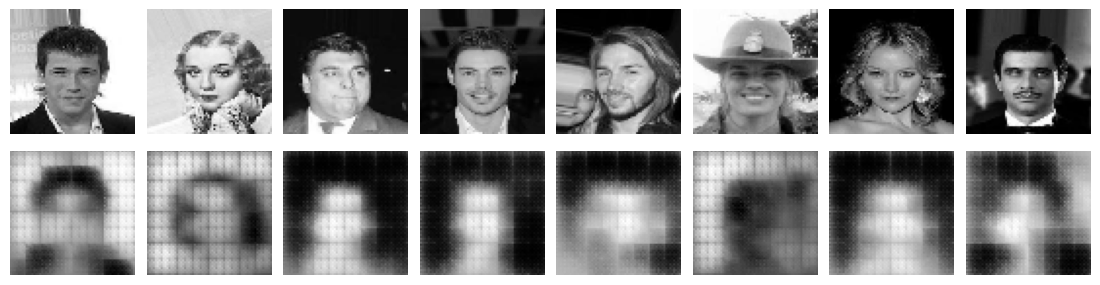

Epoch 1/2
49/49 [==============================] - 414s 8s/step - batch: 24.5000 - size: 4051.9800 - loss: 344.2402 - r_loss: 0.0300 - kl_loss: 44.3825
Epoch 2/2
49/49 [==============================] - 393s 8s/step - batch: 24.5000 - size: 4051.9800 - loss: 311.4259 - r_loss: 0.0263 - kl_loss: 48.4408


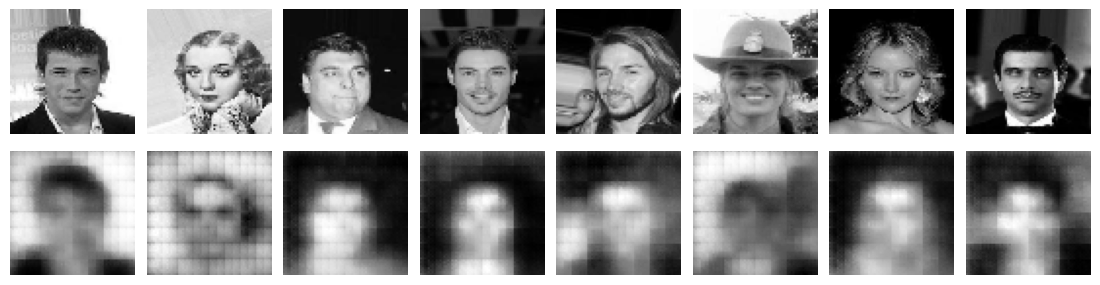

Epoch 1/2
49/49 [==============================] - 326s 7s/step - batch: 24.5000 - size: 4051.9800 - loss: 291.5122 - r_loss: 0.0240 - kl_loss: 51.2427
Epoch 2/2
49/49 [==============================] - 340s 7s/step - batch: 24.5000 - size: 4051.9800 - loss: 277.1024 - r_loss: 0.0224 - kl_loss: 52.6753


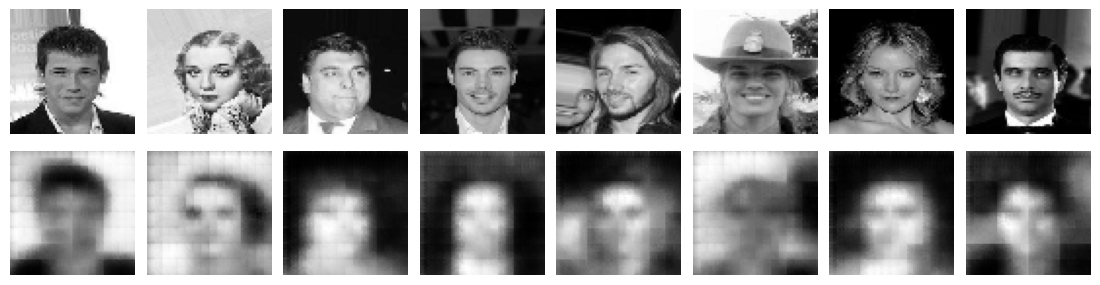

Epoch 1/2
49/49 [==============================] - 369s 7s/step - batch: 24.5000 - size: 4051.9800 - loss: 265.6710 - r_loss: 0.0213 - kl_loss: 53.0183
Epoch 2/2
49/49 [==============================] - 275s 6s/step - batch: 24.5000 - size: 4051.9800 - loss: 256.5681 - r_loss: 0.0204 - kl_loss: 52.6600


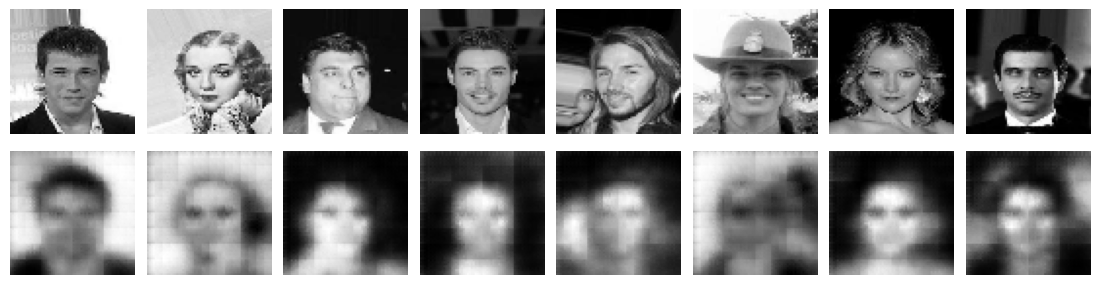

Epoch 1/2
49/49 [==============================] - 291s 6s/step - batch: 24.5000 - size: 4051.9800 - loss: 248.7505 - r_loss: 0.0197 - kl_loss: 52.1016
Epoch 2/2
49/49 [==============================] - 324s 7s/step - batch: 24.5000 - size: 4051.9800 - loss: 242.2654 - r_loss: 0.0191 - kl_loss: 51.4824


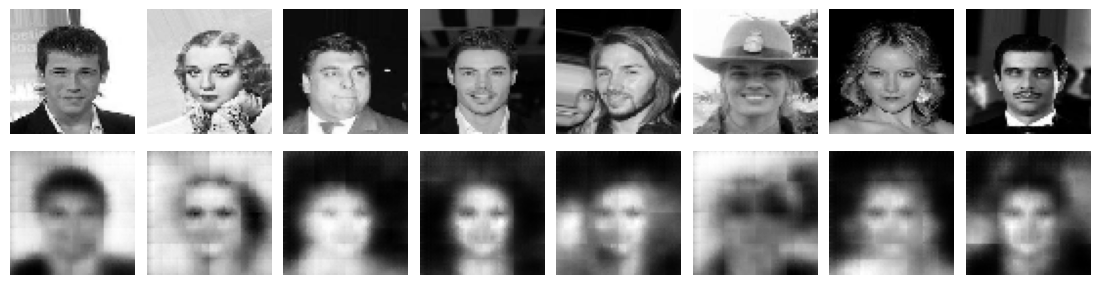

In [16]:
LEARNING_RATE = 0.0005
N_EPOCHS = 2  # No. of epochs to show advance
N_BLOCKS = 5
LOSS_FACTOR = 10000

adam_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = LEARNING_RATE)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss

def total_loss(y_true, y_pred):
    return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)



vae.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])


example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:8]

# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./vae_checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

for i in range(N_BLOCKS):
    vae.fit(data_flow, 
        shuffle=True, 
        epochs = N_EPOCHS, 
        initial_epoch = 0, 
        steps_per_epoch=NUM_IMAGES / BATCH_SIZE,
        callbacks=[model_checkpoint_callback])
    plot_compare_VAE(example_images) 

As results we can see that the obtained images are not perfect faces but we can see that the VAE was going in th right way. Probably if we had a more powerfull unit we can get good results in reasenable amount of time but that is not the case.